In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
import os
import rasterio
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
import cartopy

In [2]:
lat = np.array([49.9166666666664 - i * 0.0416666666667 for i in range(357)])
lon = np.array([-105.0416666666507 + i * 0.0416666666667 for i in range(722)])
Lon, Lat = np.meshgrid(lon, lat)

am = rasterio.open('PRISM_tmin_stable_4kmD2_19810101_bil.bil')
a = am.read()[0, :357, 479:1201]
mask = np.where(a>-1000, 1, 0)

tmin81 = np.load('./prism/mw_tmin/1981_tmin.npz')['tmin']
t, y, x = tmin81.shape
y, x

(357, 722)

In [3]:
# var_mean = [np.zeros((y, x)) * np.nan for i in range(5)]
# var_std = [np.zeros((y, x)) * np.nan for i in range(5)]
# slope = [np.zeros((y, x)) * np.nan for i in range(5)]
# pvalue = [np.zeros((y, x)) * np.nan for i in range(5)]
# X = np.linspace(1, 38, 38)
# name = ['year','sidegreen','bloom','pdays','yield']

# for i in range(y):
#     for j in range(x):
#         if mask[i, j]:
#             df = pd.read_table(f'./GDD/output_Cherry/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
#                                    names=('year','sidegreen','bloom','pdays','yield'))
#             for ii in range(1,5):
#                 var_mean[ii-1][i,j] = df[name[ii]].mean()
                
#                 var_detrend = df[name[ii]] - var_mean[ii-1][i, j]
#                 var_std[ii-1][i,j] = np.sqrt(((var_detrend - var_detrend.mean())**2).sum() / 38.)
                
#                 r = stats.linregress(X, df[name[ii]])
#                 slope[ii-1][i, j] = r.slope
#                 pvalue[ii-1][i, j] = r.pvalue
            
#             spring = df['bloom'] - df['sidegreen']
#             var_mean[-1][i,j] = spring.mean()
#             var_detrend = spring - var_mean[-1][i, j]
#             var_std[-1][i,j] = np.sqrt(((var_detrend - var_detrend.mean())**2).sum() / 38.)    
#             r = stats.linregress(X, spring)
#             slope[-1][i, j] = r.slope
#             pvalue[-1][i, j] = r.pvalue

# np.save('./GDD/var_yearly_Cherry', np.array(var_mean))
# np.save('./GDD/var_std_Cherry', np.array(var_std))
# np.save('./GDD/var_yearly__slope_Cherry', np.array(slope))
# np.save('./GDD/var_yearly_pvalue_Cherry', np.array(pvalue))

In [3]:
var_mean = np.load('./GDD/var_yearly_Cherry.npy')
var_std = np.load('./GDD/var_std_Cherry.npy')
var_slope = np.load('./GDD/var_yearly__slope_Cherry.npy')
var_pvalue = np.load('./GDD/var_yearly_pvalue_Cherry.npy')

In [4]:
data = []
pvalue = []
data.append(var_mean[0, :, :])
data.append(var_std[0, :, :])
data.append(var_slope[0, :, :])
pvalue.append(var_pvalue[0, :, :])
data.append(var_mean[1, :, :])
data.append(var_std[1, :, :])
data.append(var_slope[1, :, :])
pvalue.append(var_pvalue[1, :, :])
data.append(var_mean[4, :, :])
data.append(var_std[4, :, :])
data.append(var_slope[4, :, :])
pvalue.append(var_pvalue[4, :, :])

In [6]:
extent = [-105, -75, 34, 49]
fig, axs = plt.subplots(3, 3, figsize=(15, 9.5))
ll = [60, 0, -.6, 0, 0, -.6, 0, 0, -.6]
lr = [160, 12, .6, 160, 12, .6, 30, 12, .6]
step = [20, 2, .2, 40, 2, .2, 6, 2, .2]
title = ['(a) side green mean', '(b) side green std', '(c) side green trend', '(d) full bloom mean', 
         '(e) full bloom std', '(f) full bloom trend', '(g) spring duration mean', '(h) spring duration std', 
         '(i) spring duration trend']
pc = []
for i in range(9):
    ax = plt.subplot(3,3,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
    
    levels = MaxNLocator(nbins=100).tick_values(ll[i], lr[i])
    if i%3-2:
        cmap = plt.get_cmap('viridis')
    else:
        cmap = plt.get_cmap('bwr')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc.append(plt.pcolormesh(Lon, Lat, data[i], cmap=cmap, norm=norm, transform=ccrs.PlateCarree()))
    if i%3 == 2:
        plt.scatter(Lon, Lat, np.where(pvalue[int((i-2)/3)]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
    ax.text(.99,.95,title[i], fontsize=13, fontweight='bold',horizontalalignment='right',transform=ax.transAxes)
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.005)
i = 0
cb_ax = fig.add_axes([.005, 0.345, 0.01, 0.64])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=12) 
i = 2
cb_ax = fig.add_axes([0.985, .02, 0.01, 0.96])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='both')
cb_ax.tick_params(labelsize=12)
i = 6
cb_ax = fig.add_axes([0.005, .02, 0.01, 0.32])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=12)
i = 7
cb_ax = fig.add_axes([0.34, .005, 0.32, 0.01])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max', orientation="horizontal")
cb_ax.tick_params(labelsize=12)

plt.savefig('./plot/AgPaper/fig1.png', bbox_inches='tight')
plt.close()

<ipython-input-6-875783a1600a>:27: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[int((i-2)/3)]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


In [57]:
DamDayann = np.load('./var/DamDayann.npy')
DamDayann_slope = np.load('./var/DamDayann_slope.npy')
DamDayann_pvalue = np.load('./var/DamDayann_pvalue.npy')
data = []
pvalue = []
data.append(var_mean[3, :, :])
data.append(np.nanmean(DamDayann, axis=0))
data.append(var_std[3, :, :])
data.append(np.nanstd(DamDayann, axis=0))
data.append(var_slope[3, :, :])
data.append(DamDayann_slope)
pvalue.append(var_pvalue[3, :, :])
pvalue.append(DamDayann_pvalue)

<ipython-input-57-af3189168260>:7: RuntimeWarning: Mean of empty slice
  data.append(np.nanmean(DamDayann, axis=0))


In [60]:
extent = [-105, -75, 34, 49]
fig, axs = plt.subplots(3, 2, figsize=(10.5, 10))
ll = [0, 0, 0, 0, -.03, -.4]
lr = [1, 16, .5, 8, .03, .4]
step = [.2, 4, .1, 2, .01, .2]
title = ['(a) yield mean', '(b) damage days mean', '(c) yield std', '(d) damage days std', 
         '(e) yield trend', '(f) damage days trend']
pc = []
for i in range(6):
    ax = plt.subplot(3,2,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
    
    levels = MaxNLocator(nbins=100).tick_values(ll[i], lr[i])
    if i<4:
        cmap = plt.get_cmap('viridis')
    else:
        cmap = plt.get_cmap('bwr')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc.append(plt.pcolormesh(Lon, Lat, data[i], cmap=cmap, norm=norm, transform=ccrs.PlateCarree()))
    if i>3:
        plt.scatter(Lon, Lat, np.where(pvalue[int(i-4)]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
    ax.text(.99,.95,title[i], fontsize=13, fontweight='bold',horizontalalignment='right',transform=ax.transAxes)
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.006, hspace=0.005)
i = 0
cb_ax = fig.add_axes([.005, 0.665, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]))
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=12) 
i = 1
cb_ax = fig.add_axes([0.985, 0.665, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.tick_params(labelsize=12)
i = 2
cb_ax = fig.add_axes([0.005, .345, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=12)
i = 3
cb_ax = fig.add_axes([0.985, .345, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.tick_params(labelsize=12)
i = 4
cb_ax = fig.add_axes([0.005, .02, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=12)
i = 5
cb_ax = fig.add_axes([0.985, .02, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.tick_params(labelsize=12)

plt.savefig('./plot/AgPaper/fig2.png', bbox_inches='tight')
plt.close()

<ipython-input-60-76f07448f9f7>:26: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[int(i-4)]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


In [76]:
DamDayStage = np.load('./var/Cherry_DamDayStage.npy')
data = np.nanmean(DamDayStage, axis=0)

<ipython-input-76-75b244c082b0>:2: RuntimeWarning: Mean of empty slice
  data = np.nanmean(DamDayStage, axis=0)


In [81]:
extent = [-105, -75, 34, 49]
fig, axs = plt.subplots(3, 3, figsize=(15, 9.5))
ll = 0
lr = 1
step = .2
title = ['(a) stage 0', '(b) stage 2', '(c) stage 3', '(d) stage 4', 
         '(e) stage 5', '(f) stage 6', '(g) stage 7', '(h) stage 8', 
         '(i) stage 9']
for i in range(9):
    ax = plt.subplot(3,3,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
    
    levels = MaxNLocator(nbins=100).tick_values(ll, lr)
    cmap = plt.get_cmap('viridis_r')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, data[i, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.text(.99,.95,title[i], fontsize=13, fontweight='bold',horizontalalignment='right',transform=ax.transAxes)
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.005)
cb_ax = fig.add_axes([0.985, .02, 0.01, 0.96])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(ll, lr+step, step), extend='max')
cb_ax.tick_params(labelsize=12)

plt.savefig('./plot/AgPaper/fig3.png', bbox_inches='tight')
plt.close()

In [82]:
states = ['MI', 'ND', 'SD', 'NE', 'KS', 'OK', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'OH', 'KY', 'WV', 'PA', 'AR', 'TN', 'NY', 'MD', 'VA', 'NC']
mdmask = {states[ii]:np.load(f'./var/{states[ii]}_mask.npy') for ii in range(22)}

NWmask = np.where(np.logical_or.reduce((mdmask['ND'], mdmask['SD'], mdmask['NE'])), 1, 0)
SWmask = np.where(np.logical_or.reduce((mdmask['KS'], mdmask['OK'], mdmask['AR'])), 1, 0)
NCmask = np.where(np.logical_or.reduce((mdmask['MN'], mdmask['IA'], mdmask['WI'], mdmask['MI'])), 1, 0)
Cmask = np.where(np.logical_or.reduce((mdmask['MO'], mdmask['IL'], mdmask['IN'], mdmask['OH'], mdmask['KY'], mdmask['TN'], mdmask['WV'])), 1, 0)
NEmask = np.where(np.logical_or.reduce((mdmask['NY'], mdmask['PA'], mdmask['MD'])), 1, 0)
SEmask = np.where(np.logical_or(mdmask['VA'], mdmask['NC']), 1, 0)

In [104]:
mdmask = [NWmask, SWmask, NCmask, Cmask, NEmask, SEmask]
region = ['Northern Great Plains', 'Southern Great Plains', 'Upper Midwest', 'Ohio Valley', 'Northeast', 'Southeast']
DamDayann = np.load('./var/Cherry_DamDayann.npy')
DamDayann_states = np.zeros((38, 6))
for yl in range(38):
    DamDayann_states[yl, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDayann[yl, :, :], np.nan)) for ii in range(6)])

X = np.linspace(1981, 2018, 38)
slope = []
pvalue = []
for ri in range(6):
    r = stats.linregress(X, DamDayann_states[:, ri])
    slope.append(r.slope)
    pvalue.append(r.pvalue)

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 7))
for i in range(6):
    ax = plt.subplot(3,2,i+1)
    plt.plot(X, DamDayann_states[:, i], 'bo-', ms=3)
    plt.ylim(0, 10)
    ax.text(.01, .9, f'mean = {np.nanmean(DamDayann_states[:, i]):.2f}', fontsize='large',transform=ax.transAxes)
    ax.text(.01, .8, f'std = {np.nanstd(DamDayann_states[:, i]):.2f}', fontsize='large',transform=ax.transAxes)
    ax.text(.01, .7, f'trend = {slope[i]:.2f} (p={pvalue[i]:.4f})', fontsize='large',transform=ax.transAxes)
    ax.text(.99,.9,f'{region[i]}', fontsize='large', fontweight='bold',horizontalalignment='right',transform=ax.transAxes)
    plt.grid()
    plt.subplots_adjust(wspace=.06)
    if i % 2:
        plt.yticks(np.arange(0, 11, 2), [])
    else:
        plt.yticks(np.arange(0, 11, 2))
        
    if i<4:
        plt.xticks(np.arange(1981, 2019, 1), [])
    else:
        plt.xticks(np.arange(1981, 2019, 1), ['1981', '', '', '', '1985', '', '', '', '1989', '', '', '', '1993', '', '', '',
                                              '1997', '', '', '', '2001', '', '', '', '2005', '', '', '', '2009', '', '', '',
                                              '2013', '', '', '', '2017', '', '', ''])
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.07)    
plt.savefig('./plot/AgPaper/fig4.png', bbox_inches='tight')
plt.close()

In [180]:
def trend(slope, pvalue):
    if pvalue>=.05:
        if slope<0:
            return 'b', '-'
        else:
            return 'r', '+'
    elif pvalue < .05:
        if slope<0:
            return 'b', '-*'
        else:
            return 'r', '+*'

In [195]:
DamDayStage = np.load('./var/Cherry_DamDayStage.npy')
DamDayStage_states = np.zeros((38, 9, 6))
for yl in range(38):
    for st in range(9):
        DamDayStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDayStage[yl, st, :, :], np.nan)) for ii in range(6)])
DamDayStage_states_mean = np.nanmean(DamDayStage_states, axis=0)

DamMeanStage = np.load('./var/Cherry_DamMeanStage.npy')
DamMeanStage_states = np.zeros((38, 9, 6))
for yl in range(38):
    for st in range(9):
        DamMeanStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamMeanStage[yl, st, :, :], np.nan)) for ii in range(6)])
DamMeanStage_states_sum = np.nansum(DamMeanStage_states, axis=0)

slope_occur = np.zeros((9, 6)) * np.nan
slope_inten = np.zeros((9, 6)) * np.nan
pvalue_occur = np.zeros((9, 6)) * np.nan
pvalue_inten = np.zeros((9, 6)) * np.nan
year = np.linspace(1981, 2018, 38)
for si in range(9):
    for ri in range(6):
        r = stats.linregress(year, DamDayStage_states[:, si, ri])
        slope_occur[si, ri] = r.slope
        pvalue_occur[si, ri] = r.pvalue
        
        r = stats.linregress(year, DamMeanStage_states[:, si, ri])
        slope_inten[si, ri] = r.slope
        pvalue_inten[si, ri] = r.pvalue

X = np.linspace(0, 8, 9)
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 7))
for i in range(6):
    ax = plt.subplot(3,2,i+1)
    plt.bar(X-.2, DamDayStage_states_mean[:, i], width=.4, facecolor='orange', label='Occurrence')
    plt.bar(X+.2, DamMeanStage_states_sum[:, i], width=.4, facecolor='green', label='Intensity')
    for si in range(9):
        c, s = trend(slope_occur[si, i], pvalue_occur[si, i])
        ax.text(X[si]-.35, DamDayStage_states_mean[si, i], s, color=c, fontsize=15, fontweight='bold')
        c, s = trend(slope_inten[si, i], pvalue_inten[si, i])
        ax.text(X[si]+.05, DamMeanStage_states_sum[si, i], s, color=c, fontsize=15, fontweight='bold')
    plt.ylim(0, 1)
    plt.xticks(X, ['0', '2', '3', '4', '5', '6', '7', '8', '9'], fontsize='large')
    ax.text(.99,.9,f'{region[i]}', fontsize='large', fontweight='bold',horizontalalignment='right',transform=ax.transAxes)
    if i % 2:
        plt.yticks(np.arange(0, 1.1, .2), [])
    else:
        plt.yticks(np.arange(0, 1.1, .2), fontsize='large')
    if i>3:
        plt.legend(loc='upper left', fontsize='large', frameon=False)
    
    
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.12)    
plt.savefig('./plot/AgPaper/fig5.png', bbox_inches='tight')
plt.close()

In [209]:
TminDamStage = np.load('./var/Cherry_TminDamStage.npy')
TminDamStage_states = np.zeros((38, 9, 6))
for yl in range(38):
    for st in range(9):
        TminDamStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], TminDamStage[yl, st, :, :], np.nan)) for ii in range(6)])
TminDamStage_states_mean = np.nanmean(TminDamStage_states, axis=0)

slope = np.zeros((9, 6)) * np.nan
pvalue = np.zeros((9, 6)) * np.nan
year = np.linspace(1981, 2018, 38)
for si in range(9):
    for ri in range(6):
        r = stats.linregress(year, TminDamStage_states[:, si, ri])
        slope[si, ri] = r.slope
        pvalue[si, ri] = r.pvalue
              
X = np.linspace(0, 8, 9)
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 7))
for i in range(6):
    ax = plt.subplot(3,2,i+1)
    plt.bar(X, TminDamStage_states_mean[:, i], width=.4, facecolor='green')
    for si in range(9):
        if (not np.isnan(slope[si, i])) and  TminDamStage_states_mean[si, i]>-10:
            c, s = trend(slope[si, i], pvalue[si, i])
            ax.text(X[si]-.1, TminDamStage_states_mean[si, i]-.6, s, color=c, fontsize=15, fontweight='bold')
    ax.set_ylim(-10, 0)
    plt.xticks(X, ['0', '2', '3', '4', '5', '6', '7', '8', '9'], fontsize='large')
    ax.text(.99,.05,f'{region[i]}', fontsize='large', fontweight='bold',horizontalalignment='right',transform=ax.transAxes)
    if i % 2:
        plt.yticks(np.arange(-10, 1, 2), [])
    else:
        plt.yticks(np.arange(-10, 1, 2), fontsize='large')    
    
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.12)    
plt.savefig('./plot/AgPaper/fig6.png', bbox_inches='tight')
plt.close()

<ipython-input-209-700649536134>:5: RuntimeWarning: Mean of empty slice
  TminDamStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], TminDamStage[yl, st, :, :], np.nan)) for ii in range(6)])
<ipython-input-209-700649536134>:6: RuntimeWarning: Mean of empty slice
  TminDamStage_states_mean = np.nanmean(TminDamStage_states, axis=0)


In [211]:
DamDateStage = np.load('./var/Cherry_DamDateStage.npy')
DamDateStage_states = np.zeros((38, 9, 6))
for yl in range(38):
    for st in range(9):
        DamDateStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDateStage[yl, st, :, :], np.nan)) for ii in range(6)])
DamDateStage_states_sum = np.nanmean(DamDateStage_states, axis=0)

slope = np.zeros((9, 6)) * np.nan
pvalue = np.zeros((9, 6)) * np.nan
year = np.linspace(1981, 2018, 38)
for si in range(9):
    for ri in range(6):
        r = stats.linregress(year, DamDateStage_states[:, si, ri])
        slope[si, ri] = r.slope
        pvalue[si, ri] = r.pvalue
        
X = np.linspace(0, 8, 9)
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 7))
for i in range(6):
    ax = plt.subplot(3,2,i+1)
    plt.bar(X, DamDateStage_states_sum[:, i], width=.4, facecolor='green')
    for si in range(9):
        if not np.isnan(slope[si, i]):
            c, s = trend(slope[si, i], pvalue[si, i])
            ax.text(X[si]-.1, DamDateStage_states_sum[si, i]-.6, s, color=c, fontsize=15, fontweight='bold')
    ax.set_ylim(0, 180)
    plt.xticks(X, ['0', '2', '3', '4', '5', '6', '7', '8', '9'], fontsize='large')
    ax.text(.99,.9,f'{region[i]}', fontsize='large', fontweight='bold',horizontalalignment='right',transform=ax.transAxes)
    if i % 2:
        plt.yticks(np.arange(0, 190, 30), [])
    else:
        plt.yticks(np.arange(0, 190, 30), fontsize='large')    
    
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.12)    
plt.savefig('./plot/AgPaper/fig7.png', bbox_inches='tight')
plt.close()

<ipython-input-211-7f7a4d009df5>:5: RuntimeWarning: Mean of empty slice
  DamDateStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDateStage[yl, st, :, :], np.nan)) for ii in range(6)])
<ipython-input-211-7f7a4d009df5>:6: RuntimeWarning: Mean of empty slice
  DamDateStage_states_sum = np.nanmean(DamDateStage_states, axis=0)


### input trend

In [13]:
# tmax = np.load('./var/spring_tmax.npy') * 9. / 5. + 32.
# tmin = np.load('./var/spring_tmin.npy') * 9. / 5. + 32.
# prcp = np.load('./var/spring_prcp.npy')

# slope = np.zeros((3, y, x)) * np.nan
# pvalue = np.zeros((3, y, x)) * np.nan
# std = np.zeros((3, y, x)) * np.nan
# mean = np.zeros((3, y, x)) * np.nan
# X = np.linspace(1, 38, 38)
# data = [tmax, tmin, prcp]
# for i in range(y):
#     for j in range(x):
#         if mask[i, j]:
#             for vi in range(3):
#                 mean[vi, i, j] = np.nanmean(data[vi][:, i, j])
#                 std[vi, i, j] = np.nanstd(data[vi][:, i, j])
                
#                 r = stats.linregress(X, data[vi][:, i, j])
#                 slope[vi, i, j] = r.slope
#                 pvalue[vi, i, j] = r.pvalue
# np.save('./var/spring_input_slope', slope)   
# np.save('./var/spring_input_pvalue', pvalue)   
# np.save('./var/spring_input_mean', mean)
# np.save('./var/spring_input_std', std)   

In [14]:
var_mean = np.load('./var/spring_input_mean.npy')
var_std = np.load('./var/spring_input_std.npy')
var_slope = np.load('./var/spring_input_slope.npy')
var_pvalue = np.load('./var/spring_input_pvalue.npy')

In [15]:
data = []
pvalue = []
for i in range(3):
    data.append(var_mean[i, :, :])
    data.append(var_std[i, :, :])
    data.append(var_slope[i, :, :])
    pvalue.append(var_pvalue[i, :, :])

<ipython-input-32-fa2122180483>:28: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[int((i-2)/3)]<0.05, 1, np.nan), 'grey', alpha=.05, transform=ccrs.PlateCarree())


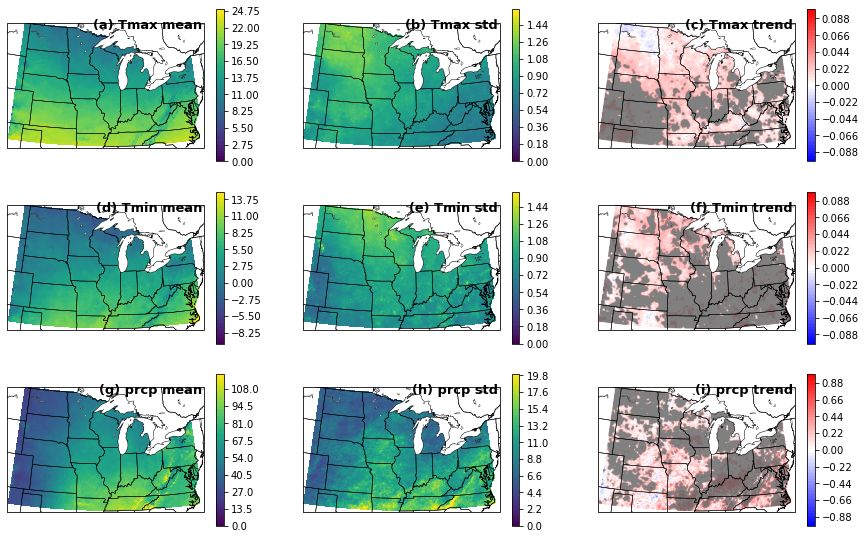

In [32]:
extent = [-105, -75, 34, 49]
fig, axs = plt.subplots(3, 3, figsize=(15, 9.5))
ll = [0, 0, -.1, -10, 0, -.1, 0, 0, -1]
lr = [25, 1.6, .1, 15, 1.6, .1, 120, 20, 1]
step = [5, .4, .05, 8, 5, .05, 30, 4, .5]
title = ['(a) Tmax mean', '(b) Tmax std', '(c) Tmax trend', '(d) Tmin mean', 
         '(e) Tmin std', '(f) Tmin trend', '(g) prcp mean', '(h) prcp std', 
         '(i) prcp trend']
pc = []
for i in range(9):
    ax = plt.subplot(3,3,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
    
    levels = MaxNLocator(nbins=100).tick_values(ll[i], lr[i])
    if i%3-2:
        cmap = plt.get_cmap('viridis')
    else:
        cmap = plt.get_cmap('bwr')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc.append(plt.pcolormesh(Lon, Lat, data[i], cmap=cmap, norm=norm, transform=ccrs.PlateCarree()))
    plt.colorbar()
    if i%3 == 2:
        plt.scatter(Lon, Lat, np.where(pvalue[int((i-2)/3)]<0.05, 1, np.nan), 'grey', alpha=.05, transform=ccrs.PlateCarree())
    ax.text(.99,.95,title[i], fontsize=13, fontweight='bold',horizontalalignment='right',transform=ax.transAxes)
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.005)
# plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
#                     wspace=0.005, hspace=0.005)
# i = 0
# cb_ax = fig.add_axes([.005, 0.345, 0.01, 0.64])
# cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
# cb_ax.yaxis.set_ticks_position('left')
# cb_ax.tick_params(labelsize=12) 
# i = 2
# cb_ax = fig.add_axes([0.985, .02, 0.01, 0.96])
# cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='both')
# cb_ax.tick_params(labelsize=12)
# i = 6
# cb_ax = fig.add_axes([0.005, .02, 0.01, 0.32])
# cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
# cb_ax.yaxis.set_ticks_position('left')
# cb_ax.tick_params(labelsize=12)
# i = 7
# cb_ax = fig.add_axes([0.34, .005, 0.32, 0.01])
# cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max', orientation="horizontal")
# cb_ax.tick_params(labelsize=12)

# plt.savefig('./plot/AgPaper/fig1.png', bbox_inches='tight')
# plt.close()
plt.show()